In [111]:
import pandas as pd

file_path = 'C:/Users/syeds/Desktop/Modules/Dissertation/gw_153_predictions.csv'
data = pd.read_csv(file_path)

In [343]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Load the dataset
file_path = 'C:/Users/syeds/Desktop/Modules/Dissertation/gw_153_predictions.csv'
data = pd.read_csv(file_path)gur

# Filter the data for GW 115
gw_115_data = data[data['GW'] == 141]

# Gurobi Model for FPL Optimization
def fpl_optimizer(gw_115_data, budget_limit=100, max_team_players=3, formation="1-3-4-3"):
    
    # Initialize model
    model = gp.Model("FPL_Optimizer")
    
    # Set formations
    formations = {
        "1-3-4-3": {"GK": 1, "DEF": 3, "MID": 4, "FWD": 3},
        "1-4-4-2": {"GK": 1, "DEF": 4, "MID": 4, "FWD": 2},
        "1-3-5-2": {"GK": 1, "DEF": 3, "MID": 5, "FWD": 2}
    }
    bench_formations = {
        "1-3-4-3": {"GK": 1, "DEF": 2, "MID": 1, "FWD": 0},
        "1-4-4-2": {"GK": 1, "DEF": 1, "MID": 1, "FWD": 1},
        "1-3-5-2": {"GK": 1, "DEF": 2, "MID": 0, "FWD": 1}
    }
    
    required_positions = formations[formation]
    bench_positions = bench_formations[formation]
    
    # Create decision variables
    players = gw_115_data['name'].tolist()
    predicted_points = dict(zip(players, gw_115_data['Predicted_Points']))
    values = dict(zip(players, gw_115_data['value']))
    positions = dict(zip(players, gw_115_data['position']))
    teams = dict(zip(players, gw_115_data['team']))

    x = model.addVars(players, vtype=GRB.BINARY, name="x")  # Decision variables (1 if selected, 0 otherwise)
    
    # Objective: Maximize predicted points
    model.setObjective(gp.quicksum(x[player] * predicted_points[player] for player in players), GRB.MAXIMIZE)
    
    # Constraint: Total value of selected players must be within the budget
    model.addConstr(gp.quicksum(x[player] * values[player] for player in players) <= budget_limit, name="Budget")
    
    # Constraints: Number of players by position in the starting 11
    for pos, count in required_positions.items():
        model.addConstr(gp.quicksum(x[player] for player in players if positions[player] == pos) == count, name=f"{pos}_constraint")
    
    # Constraints: Number of players by position on the bench
    total_bench_players = 4
    for pos, count in bench_positions.items():
        model.addConstr(gp.quicksum(x[player] for player in players if positions[player] == pos) >= count, name=f"{pos}_bench_constraint")
    
    # Constraint: Max 3 players per team
    for team in gw_115_data['team'].unique():
        model.addConstr(gp.quicksum(x[player] for player in players if teams[player] == team) <= max_team_players, name=f"{team}_limit")
    
    # Solve the model
    model.optimize()
    
    # Get the results
    selected_players = [player for player in players if x[player].x > 0.5]
    
    # Prepare the final squad for output
    starting_11 = []
    bench = []
    
    # Select starting 11 and bench based on constraints
    for pos, count in required_positions.items():
        pos_players = [p for p in selected_players if positions[p] == pos]
        starting_11.extend(pos_players[:count])
        bench.extend(pos_players[count:])
    
    # Sort the remaining players for the bench based on budget and predicted points
    remaining_data = gw_115_data[~gw_115_data['name'].isin(starting_11)]
    
    # Fill bench with the best possible low-cost players while keeping within the budget
    for pos, count in bench_positions.items():
        pos_bench_players = remaining_data[remaining_data['position'] == pos].sort_values(by='value', ascending=True)
        for _, player in pos_bench_players.iterrows():
            if len([p for p in bench if positions[p] == pos]) < count:
                bench.append(player['name'])
    
    return starting_11, bench, model.ObjVal  # Return starting 11, bench, and the optimized points

# Call the optimizer function
starting_11, bench, total_predicted_points = fpl_optimizer(gw_115_data)

# Output results
print("Selected Starting 11 FPL Team for GW 115:")
for player in starting_11:
    player_data = gw_115_data[gw_115_data['name'] == player].iloc[0]
    print(f"{player_data['name']} ({player_data['team']}, {player_data['position']}): Predicted Points: {player_data['Predicted_Points']}, Value: {player_data['value']}, Actual Points: {player_data['next_GW_total_points']}")
    
print("\nBench players:")
for player in bench:
    player_data = gw_115_data[gw_115_data['name'] == player].iloc[0]
    print(f"{player_data['name']} ({player_data['team']}, {player_data['position']}): Predicted Points: {player_data['Predicted_Points']}, Value: {player_data['value']}, Actual Points: {player_data['next_GW_total_points']}")
    
print(f"\nTotal Predicted Points for Starting 11 and Bench: {total_predicted_points}")

Selected Starting 11 FPL Team for GW 115:
andre onana (Man Utd, GK): Predicted Points: 2.102871417999268, Value: 4.8, Actual Points: 11.0
benjamin white (Arsenal, DEF): Predicted Points: 1.3083337545394895, Value: 5.6, Actual Points: 11.0
gabriel dos santos magalhaes (Arsenal, DEF): Predicted Points: 1.3103591203689575, Value: 5.3, Actual Points: 1.0
kieran trippier (Newcastle, DEF): Predicted Points: 1.352060317993164, Value: 6.9, Actual Points: 0.0
bukayo saka (Arsenal, MID): Predicted Points: 9.584828377, Value: 9.2, Actual Points: 2.0
cole palmer (Chelsea, MID): Predicted Points: 9.082818031311035, Value: 5.7, Actual Points: 13.0
phil foden (Man City, MID): Predicted Points: 9.386627197265623, Value: 8.1, Actual Points: 2.0
richarlison de andrade (Spurs, MID): Predicted Points: 9.100076675, Value: 7.1, Actual Points: 0.0
erling haaland (Man City, FWD): Predicted Points: 2.321122169494629, Value: 14.5, Actual Points: 2.0
nicolas jackson (Chelsea, FWD): Predicted Points: 2.097789049,

In [113]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Load the dataset (replace with the actual file path for GW 116 predictions)
file_path = 'C:/Users/syeds/Desktop/Modules/Dissertation/gw_153_predictions.csv'  # GW 116 data
data = pd.read_csv(file_path)

# Ensure unique player identifiers by combining player name, team, and GW
data['unique_player_id'] = data['name'] + '_' + data['team'] + '_GW' + data['GW'].astype(str)

# Initial Squad from GW 115 (update to GW 116 format)
initial_starting_11 = [
    'bernd leno_Fulham_GW116', 'axel disasi_Chelsea_GW116', 'joachim andersen_Crystal Palace_GW116',
    'nelson cabral semedo_Wolves_GW116', 'eberechi eze_Crystal Palace_GW116', 'mohamed salah_Liverpool_GW116',
    'moussa diaby_Aston Villa_GW116', 'sandro tonali_Newcastle_GW116', 'callum wilson_Newcastle_GW116',
    'erling haaland_Man City_GW116', 'yoane wissa_Brentford_GW116'
]

initial_bench = [
    'fraser forster_Spurs_GW116', 'malo gusto_Chelsea_GW116', 'jarell quansah_Liverpool_GW116', 'jeremy sarmiento morante_Brighton_GW116'
]

# Load the data for GW 116
gw116_data = data[data['GW'] == 116].copy()

# Ensure unique player ID is used for each player
gw116_data['unique_player_id'] = gw116_data['name'] + '_' + gw116_data['team'] + '_GW' + gw116_data['GW'].astype(str)

# Remove any duplicate player IDs
gw116_data = gw116_data.drop_duplicates(subset='unique_player_id')

# Function to optimize the squad for GW 116 with 1 transfer, including the bench
def fpl_optimizer_one_transfer(gw_data, current_starting_11, current_bench, budget_limit=100, max_team_players=3):
    gp.setParam('OutputFlag', 0)
    model = gp.Model("FPL_Optimizer")
    
    # Define positions and decision variables
    players = gw_data['unique_player_id'].tolist()
    predicted_points = dict(zip(players, gw_data['Predicted_Points']))
    values = dict(zip(players, gw_data['value']))
    positions = dict(zip(players, gw_data['position']))
    teams = dict(zip(players, gw_data['team']))

    x = model.addVars(players, vtype=GRB.BINARY, name="x")
    
    # Objective: Maximize predicted points
    model.setObjective(gp.quicksum(x[player] * predicted_points[player] for player in players), GRB.MAXIMIZE)
    
    # Budget constraint
    model.addConstr(gp.quicksum(x[player] * values[player] for player in players) <= budget_limit, name="Budget")
    
    # Max 3 players from the same team
    for team in gw_data['team'].unique():
        model.addConstr(gp.quicksum(x[player] for player in players if teams[player] == team) <= max_team_players, name=f"{team}_limit")

    # Solve the model
    model.optimize()

    # Extract the selected players
    selected_players = [player for player in players if x[player].x > 0.5]

    # Transfer logic: Select the best player to replace one player in the current team
    best_transfer = None
    best_transfer_gain = 0
    for new_player in selected_players:
        if new_player not in current_starting_11 and new_player not in current_bench:
            for old_player in current_starting_11:
                predicted_points_gain = predicted_points[new_player] - predicted_points[old_player]
                if predicted_points_gain > best_transfer_gain:
                    best_transfer_gain = predicted_points_gain
                    best_transfer = (old_player, new_player)
    
    if best_transfer:
        print(f"Transferring OUT {best_transfer[0]} and IN {best_transfer[1]} for GW 116")
        current_starting_11.remove(best_transfer[0])
        current_starting_11.append(best_transfer[1])
    
    return current_starting_11, current_bench  # Return both starting 11 and bench

# Call the optimizer for GW 116 with 1 transfer
final_starting_11, final_bench = fpl_optimizer_one_transfer(gw116_data, initial_starting_11, initial_bench)

# Display the final starting 11 after the transfer
print("\nFinal Starting 11 for GW 116:")
print(gw116_data[gw116_data['unique_player_id'].isin(final_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'value']])

# Display the bench after the transfer
print("\nFinal Bench for GW 116:")
print(gw116_data[gw116_data['unique_player_id'].isin(final_bench)][['name', 'team', 'position', 'Predicted_Points', 'value']])


# Calculate total predicted points for starting 11
total_predicted_points_starting_11 = gw116_data[gw116_data['unique_player_id'].isin(final_starting_11)]['Predicted_Points'].sum()

# Calculate total predicted points for the bench
total_predicted_points_bench = gw116_data[gw116_data['unique_player_id'].isin(final_bench)]['Predicted_Points'].sum()

# Calculate total predicted points for the full team (starting 11 + bench)
total_predicted_points = total_predicted_points_starting_11 + total_predicted_points_bench

# Calculate total predicted points for starting 11
total_predicted_points_starting_11 = gw116_data[gw116_data['unique_player_id'].isin(final_starting_11)]['Predicted_Points'].sum()

# Calculate total actual points for starting 11
total_actual_points_starting_11 = gw116_data[gw116_data['unique_player_id'].isin(final_starting_11)]['next_GW_total_points'].sum()

# Calculate total predicted points for the bench
total_predicted_points_bench = gw116_data[gw116_data['unique_player_id'].isin(final_bench)]['Predicted_Points'].sum()

# Calculate total actual points for the bench
total_actual_points_bench = gw116_data[gw116_data['unique_player_id'].isin(final_bench)]['next_GW_total_points'].sum()

# Calculate total predicted points for the full team (starting 11 + bench)
total_predicted_points = total_predicted_points_starting_11 + total_predicted_points_bench

# Calculate total actual points for the full team (starting 11 + bench)
total_actual_points = total_actual_points_starting_11 + total_actual_points_bench

# Display the final starting 11
print("\nFinal Starting 11 for GW 116:")
print(gw116_data[gw116_data['unique_player_id'].isin(final_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

# Display the final bench
print("\nFinal Bench for GW 116:")
print(gw116_data[gw116_data['unique_player_id'].isin(final_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

# Display total predicted and actual points
print(f"\nTotal Predicted Points for Starting 11: {total_predicted_points_starting_11}")
print(f"Total Actual Points for Starting 11: {total_actual_points_starting_11}")
print(f"Total Predicted Points for Bench: {total_predicted_points_bench}")
print(f"Total Actual Points for Bench: {total_actual_points_bench}")
print(f"Total Predicted Points for Full Team: {total_predicted_points}")
print(f"Total Actual Points for Full Team: {total_actual_points}")

Transferring OUT nelson cabral semedo_Wolves_GW116 and IN diogo teixeira da silva_Liverpool_GW116 for GW 116

Final Starting 11 for GW 116:
                          name            team position  Predicted_Points  \
46047              axel disasi         Chelsea      DEF          1.148672   
46173               bernd leno          Fulham       GK          1.933149   
46187            callum wilson       Newcastle      FWD          9.430373   
46366  diogo teixeira da silva       Liverpool      MID          9.522470   
46371             eberechi eze  Crystal Palace      MID          9.272383   
46384           erling haaland        Man City      FWD          9.715726   
46628         joachim andersen  Crystal Palace      DEF          1.111374   
46874            mohamed salah       Liverpool      MID          9.450327   
46877             moussa diaby     Aston Villa      MID          2.007337   
46976            sandro tonali       Newcastle      MID          2.021003   
47136        

In [114]:
import pandas as pd

# Load the data
data = pd.read_csv('C:/Users/syeds/Desktop/Modules/Dissertation/gw_153_predictions.csv')

# Sample initial starting 11 and bench for GW 115
initial_starting_11 = [
    'bernd leno_Fulham_GW115', 'axel disasi_Chelsea_GW115', 
    'joachim andersen_Crystal Palace_GW115', 'nelson cabral semedo_Wolves_GW115', 
    'eberechi eze_Crystal Palace_GW115', 'mohamed salah_Liverpool_GW115', 
    'moussa diaby_Aston Villa_GW115', 'sandro tonali_Newcastle_GW115', 
    'callum wilson_Newcastle_GW115', 'erling haaland_Man City_GW115', 
    'yoane wissa_Brentford_GW115'
]

initial_bench = [
    'fraser forster_Spurs_GW115', 'malo gusto_Chelsea_GW115', 
    'jarell quansah_Liverpool_GW115', 'jeremy sarmiento morante_Brighton_GW115'
]

In [132]:
def remove_duplicate_players(gw_data):
    """
    For players with duplicate entries in the same GW, keep the record with the highest predicted points.
    """
    gw_data = gw_data.sort_values('Predicted_Points', ascending=False)
    return gw_data.drop_duplicates(subset=['name', 'team'], keep='first')


In [133]:
def update_player_ids(starting_11, bench, gw):
    """
    Update the player IDs for the new gameweek, ensuring no duplicates.
    """
    updated_starting_11 = list(set([p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in starting_11]))
    updated_bench = list(set([p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in bench]))
    return updated_starting_11, updated_bench


In [134]:
def fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=None):
    """
    Substitute better bench players into the starting 11 before making transfers.
    """
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))

    # Check if any bench player can improve the starting 11
    for bench_player in current_bench:
        if bench_player in predicted_points:  # Ensure player exists in the predicted data
            bench_position = position_mapping[bench_player]
            for starting_player in current_starting_11:
                if starting_player in predicted_points:  # Ensure player exists in the predicted data
                    starting_position = position_mapping[starting_player]

                    # Ensure the positions match before substitution
                    if bench_position == starting_position and predicted_points.get(bench_player, 0) > predicted_points.get(starting_player, 0):
                        print(f"Substituting {starting_player} with {bench_player} from the bench")
                        current_starting_11.remove(starting_player)
                        current_starting_11.append(bench_player)
                        current_bench.remove(bench_player)
                        current_bench.append(starting_player)
                        break  # One substitution at a time

    return current_starting_11, current_bench


In [135]:
def fpl_optimizer_one_transfer(gw_data, current_starting_11, current_bench, budget_limit=100, formation=None):
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))
    transfer_made = False
    best_transfer_gain = 0
    best_transfer = None

    # Try to transfer from the market if no better bench option
    for new_player in gw_data['unique_player_id']:
        new_position = position_mapping[new_player]
        if new_player not in current_starting_11 and new_player not in current_bench:
            for old_player in current_starting_11:
                old_position = position_mapping[old_player]
                if old_position == new_position and new_player in predicted_points and old_player in predicted_points:
                    predicted_points_gain = predicted_points[new_player] - predicted_points[old_player]
                    if predicted_points_gain > best_transfer_gain:
                        best_transfer_gain = predicted_points_gain
                        best_transfer = (new_player, old_player)

    # Perform the transfer if it's beneficial
    if best_transfer:
        new_player, old_player = best_transfer
        current_starting_11.remove(old_player)
        current_starting_11.append(new_player)
        transfer_made = True
        print(f"Transferring OUT {old_player} and IN {new_player}")

    return current_starting_11, current_bench, transfer_made


In [136]:
def assign_captain_and_vice_captain(starting_11, gw_data):
    """
    Assign captain and vice-captain to the two players with the highest predicted points.
    The captain's points are doubled.
    """
    starting_players_data = gw_data[gw_data['unique_player_id'].isin(starting_11)]
    sorted_players = starting_players_data.sort_values('Predicted_Points', ascending=False)
    captain = sorted_players.iloc[0]['unique_player_id']
    vice_captain = sorted_players.iloc[1]['unique_player_id']
    print(f"Captain: {captain}, Vice-Captain: {vice_captain}")
    return captain, vice_captain


In [137]:
def simulate_full_season_with_bench(data, initial_starting_11, initial_bench, free_transfers=1, max_transfers=5, transfer_cost=4, formation=None):
    """
    Simulates the FPL season from GW 115 to 152, managing transfers, bench substitutions, and points for each GW.
    """
    total_predicted_points = 0
    total_actual_points = 0
    total_value = 0
    transfer_bank = free_transfers
    current_starting_11 = initial_starting_11.copy()
    current_bench = initial_bench.copy()

    gw_predictions = []
    gw_actuals = []
    gw_values = []

    for gw in range(115, 153):  # Loop through GWs 115 to 152
        gw_data = data[data['GW'] == gw].copy()
        gw_data = remove_duplicate_players(gw_data)  # Handle duplicate player entries

        # Update unique player IDs for the new GW
        current_starting_11, current_bench = update_player_ids(current_starting_11, current_bench, gw)

        # Ensure the starting 11 and bench are valid for the new GW
        gw_data['unique_player_id'] = gw_data['name'] + '_' + gw_data['team'] + '_GW' + gw_data['GW'].astype(str)
        current_starting_11 = [p for p in current_starting_11 if p in gw_data['unique_player_id'].values]
        current_bench = [p for p in current_bench if p in gw_data['unique_player_id'].values]

        # Substituting better bench players before making transfers
        current_starting_11, current_bench = fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=formation)

        # Assign captain and vice-captain
        captain, vice_captain = assign_captain_and_vice_captain(current_starting_11, gw_data)

        # Calculate current predicted and actual points
        current_predicted_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['Predicted_Points'].sum()
        current_actual_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['next_GW_total_points'].sum()

        # Double the captain's points
        current_predicted_points += gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]  # Double captain's points
        current_actual_points += gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]  # Double captain's actual points

        # Calculate the total squad value (starting 11 + bench)
        total_squad_value = gw_data[gw_data['unique_player_id'].isin(current_starting_11 + current_bench)]['value'].sum()

        # Optionally make transfers as needed, update transfer bank
        transfer_made = False
        if transfer_bank > 0:
            # Use 1 or more transfers depending on the banked transfers
            for _ in range(min(transfer_bank, max_transfers)):
                final_starting_11, final_bench, made_transfer = fpl_optimizer_one_transfer(gw_data, current_starting_11, current_bench, formation=formation)
                current_starting_11 = final_starting_11
                current_bench = final_bench
                if made_transfer:
                    transfer_bank -= 1
                    transfer_made = True

        if not transfer_made:
            transfer_bank = min(transfer_bank + 1, 2)  # Save transfer if none made, cap at 2
        else:
            transfer_bank = 1  # Reset to 1 after making a transfer

        # Print results for each GW
        print(f"\nGameweek {gw} - Starting 11:")
        print(gw_data[gw_data['unique_player_id'].isin(current_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])
        print(f"Bench for GW {gw}:")
        print(gw_data[gw_data['unique_player_id'].isin(current_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

        # Update total points and value
        total_predicted_points += current_predicted_points
        total_actual_points += current_actual_points
        total_value += total_squad_value

        # Collect data for chart
        gw_predictions.append(current_predicted_points)
        gw_actuals.append(current_actual_points)
        gw_values.append(total_squad_value)

        print(f"Total Predicted Points for GW {gw}: {current_predicted_points}")
        print(f"Total Actual Points for GW {gw}: {current_actual_points}")
        print(f"Total Transfer Bank after GW {gw}: {transfer_bank}")
        print(f"Total Squad Value for GW {gw}: {total_squad_value}")

    return total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values


Captain: erling haaland_Man City_GW115, Vice-Captain: callum wilson_Newcastle_GW115

Gameweek 115 - Starting 11:
                       name            team position  Predicted_Points  \
47769        erling haaland        Man City      FWD         10.389618   
47476         callum wilson       Newcastle      FWD          9.557711   
48200         mohamed salah       Liverpool      MID          9.508635   
47639          eberechi eze  Crystal Palace      MID          9.433738   
48428           yoane wissa       Brentford      FWD          9.432960   
48203          moussa diaby     Aston Villa      MID          9.284191   
48264         sandro tonali       Newcastle      MID          9.014761   
47462            bernd leno          Fulham       GK          7.879585   
47409           axel disasi         Chelsea      DEF          7.252136   
47842      joachim andersen  Crystal Palace      DEF          1.303292   
48214  nelson cabral semedo          Wolves      DEF          1.290114   

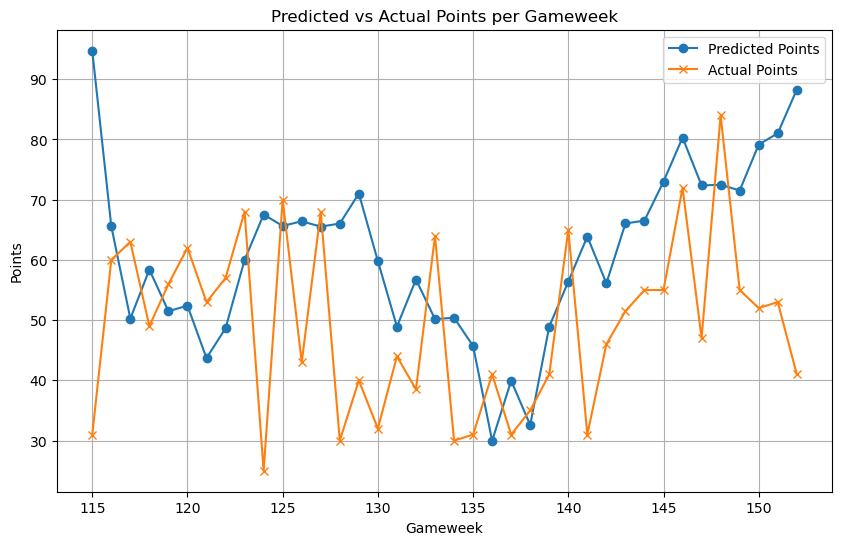

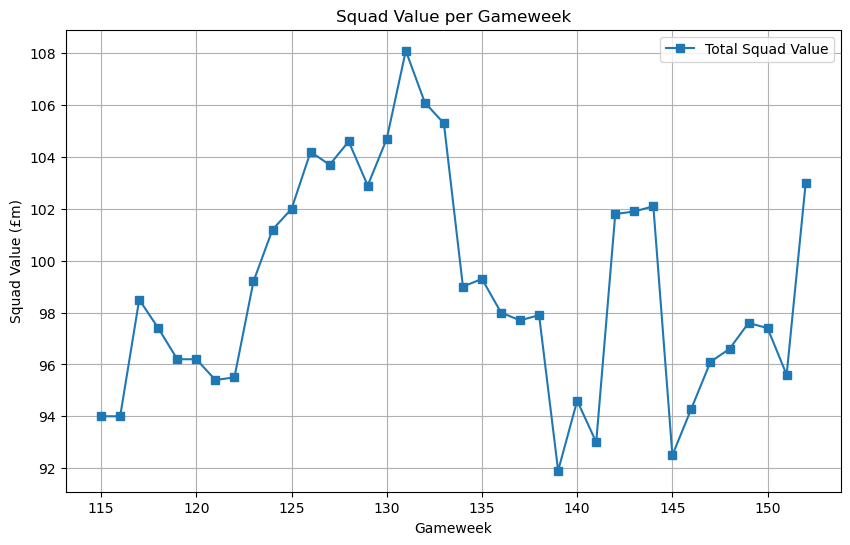

In [138]:
import matplotlib.pyplot as plt

# Simulate the full season
total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values = simulate_full_season_with_bench(data, initial_starting_11, initial_bench)

print(f"\nTotal Predicted Points for the full season: {total_predicted_points}")
print(f"Total Actual Points for the full season: {total_actual_points}")

# Plot the comparison chart for predicted and actual points
plt.figure(figsize=(10, 6))
plt.plot(range(115, 153), gw_predictions, label='Predicted Points', marker='o')
plt.plot(range(115, 153), gw_actuals, label='Actual Points', marker='x')
plt.xlabel('Gameweek')
plt.ylabel('Points')
plt.title('Predicted vs Actual Points per Gameweek')
plt.legend()
plt.grid(True)
plt.show()

# Plot the total squad value per GW
plt.figure(figsize=(10, 6))
plt.plot(range(115, 153), gw_values, label='Total Squad Value', marker='s')
plt.xlabel('Gameweek')
plt.ylabel('Squad Value (£m)')
plt.title('Squad Value per Gameweek')
plt.legend()
plt.grid(True)
plt.show()


Captain: erling haaland_Man City_GW115, Vice-Captain: callum wilson_Newcastle_GW115
Transferring OUT nelson cabral semedo_Wolves_GW115 and IN destiny udogie_Spurs_GW115 for the next 5 GWs

Gameweek 115 - Starting 11:
                   name            team position  Predicted_Points  \
47769    erling haaland        Man City      FWD         10.389618   
47476     callum wilson       Newcastle      FWD          9.557711   
48200     mohamed salah       Liverpool      MID          9.508635   
47639      eberechi eze  Crystal Palace      MID          9.433738   
48428       yoane wissa       Brentford      FWD          9.432960   
48203      moussa diaby     Aston Villa      MID          9.284191   
48264     sandro tonali       Newcastle      MID          9.014761   
47462        bernd leno          Fulham       GK          7.879585   
47409       axel disasi         Chelsea      DEF          7.252136   
47842  joachim andersen  Crystal Palace      DEF          1.303292   
47631    dest

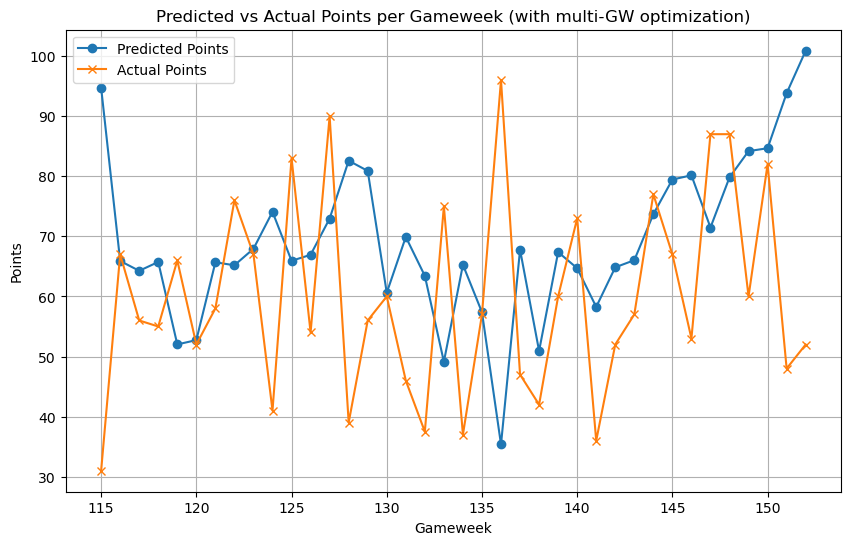

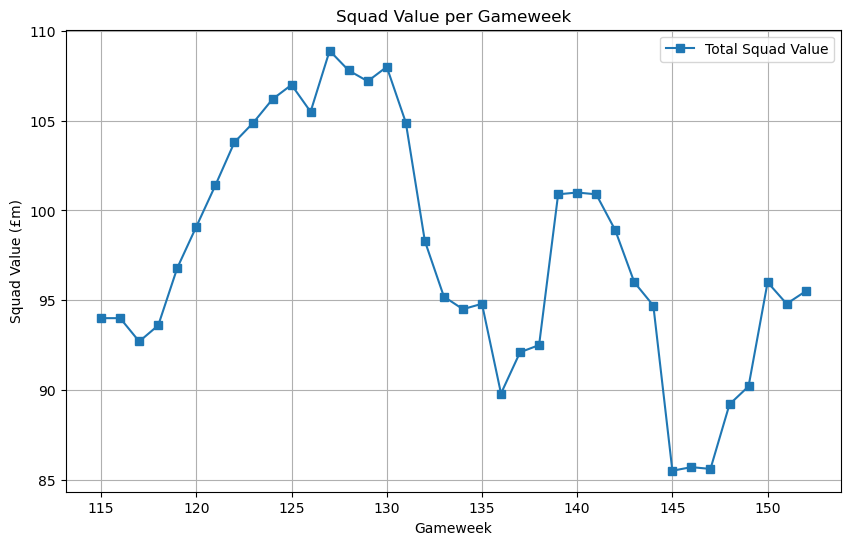

In [244]:
import pandas as pd
import matplotlib.pyplot as plt

def ensure_unique_player_id(data):
    """
    Ensure that a unique_player_id column exists by concatenating player name, team, and GW.
    """
    if 'unique_player_id' not in data.columns:
        data['unique_player_id'] = data['name'] + '_' + data['team'] + '_GW' + data['GW'].astype(str)
    return data

def remove_duplicate_players(gw_data):
    """
    For players with duplicate entries in the same GW, keep the record with the highest predicted points.
    """
    gw_data = ensure_unique_player_id(gw_data)
    gw_data = gw_data.sort_values('Predicted_Points', ascending=False)
    return gw_data.drop_duplicates(subset=['unique_player_id'], keep='first')

def update_player_ids(starting_11, bench, gw):
    """
    Update the player IDs for the new gameweek.
    """
    updated_starting_11 = [p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in starting_11]
    updated_bench = [p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in bench]
    return updated_starting_11, updated_bench

def fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=None):
    """
    Substitute better bench players into the starting 11 before making transfers.
    """
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))

    for bench_player in current_bench.copy():
        if bench_player in predicted_points:
            bench_position = position_mapping[bench_player]
            for starting_player in current_starting_11.copy():
                if starting_player in predicted_points:
                    starting_position = position_mapping[starting_player]

                    if bench_position == starting_position and predicted_points[bench_player] > predicted_points[starting_player]:
                        print(f"Substituting {starting_player} with {bench_player} from the bench")
                        current_starting_11.remove(starting_player)
                        current_starting_11.append(bench_player)
                        current_bench.remove(bench_player)
                        current_bench.append(starting_player)
                        break

    return current_starting_11, current_bench

def assign_captain_and_vice_captain(starting_11, gw_data):
    """
    Assign captain and vice-captain to the two players with the highest predicted points.
    The captain's points are doubled.
    """
    starting_players_data = gw_data[gw_data['unique_player_id'].isin(starting_11)]
    sorted_players = starting_players_data.sort_values('Predicted_Points', ascending=False)

    if len(sorted_players) < 2:
        print("Not enough players for captain/vice-captain assignment!")
        return None, None

    captain = sorted_players.iloc[0]['unique_player_id']
    vice_captain = sorted_players.iloc[1]['unique_player_id']
    print(f"Captain: {captain}, Vice-Captain: {vice_captain}")
    return captain, vice_captain

def fpl_optimizer_one_transfer_multi_gw(gw_data, current_starting_11, current_bench, all_gw_data, gw, lookahead_gws=5, budget_limit=100, formation=None):
    """
    Optimize transfers based on predicted points over the next few gameweeks (lookahead_gws).
    """
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))
    transfer_made = False
    best_transfer_gain = 0
    best_transfer = None

    # Ensure 'unique_player_id' exists in all_gw_data
    all_gw_data = ensure_unique_player_id(all_gw_data)

    def sum_predicted_points_over_gws(player_name, current_gw, lookahead_gws):
        future_gws = all_gw_data[
            (all_gw_data['name'] == player_name.split('_')[0]) &  # Split to get player name
            (all_gw_data['GW'] >= current_gw) &
            (all_gw_data['GW'] < current_gw + lookahead_gws)
        ]
        return future_gws['Predicted_Points'].sum()

    for new_player in gw_data['unique_player_id']:
        new_position = position_mapping[new_player]
        new_player_name = new_player.split('_')[0]
        if new_player not in current_starting_11 and new_player not in current_bench:
            for old_player in current_starting_11:
                old_position = position_mapping[old_player]
                old_player_name = old_player.split('_')[0]
                if old_position == new_position:
                    old_player_sum_points = sum_predicted_points_over_gws(old_player_name, gw, lookahead_gws)
                    new_player_sum_points = sum_predicted_points_over_gws(new_player_name, gw, lookahead_gws)
                    predicted_points_gain = new_player_sum_points - old_player_sum_points
                    if predicted_points_gain > best_transfer_gain:
                        best_transfer_gain = predicted_points_gain
                        best_transfer = (new_player, old_player)

    if best_transfer:
        new_player, old_player = best_transfer
        current_starting_11.remove(old_player)
        current_starting_11.append(new_player)
        transfer_made = True
        print(f"Transferring OUT {old_player} and IN {new_player} for the next {lookahead_gws} GWs")

    return current_starting_11, current_bench, transfer_made



def simulate_full_season_with_bench_multi_gw(data, initial_starting_11, initial_bench, free_transfers=1, max_transfers=1, transfer_cost=4, formation=None, lookahead_gws=5):
    """
    Simulates the FPL season, managing transfers, bench substitutions, and points for each GW.
    Now includes multi-week optimization strategy for transfers.
    """
    # Ensure 'unique_player_id' exists in the main data DataFrame
    data = ensure_unique_player_id(data)

    total_predicted_points = 0
    total_actual_points = 0
    total_value = 0
    transfer_bank = free_transfers
    current_starting_11 = initial_starting_11.copy()
    current_bench = initial_bench.copy()

    gw_predictions = []
    gw_actuals = []
    gw_values = []

    for gw in range(115, 153):
        gw_data = data[data['GW'] == gw].copy()
        gw_data = remove_duplicate_players(gw_data)

        gw_data = ensure_unique_player_id(gw_data)

        current_starting_11, current_bench = update_player_ids(current_starting_11, current_bench, gw)

        current_starting_11 = [p for p in current_starting_11 if p in gw_data['unique_player_id'].values]
        current_bench = [p for p in current_bench if p in gw_data['unique_player_id'].values]

        current_starting_11, current_bench = fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=formation)

        captain, vice_captain = assign_captain_and_vice_captain(current_starting_11, gw_data)

        current_predicted_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['Predicted_Points'].sum()
        current_actual_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['next_GW_total_points'].sum()

        if captain:
            current_predicted_points += gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]
            current_actual_points += gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]

        total_squad_value = gw_data[gw_data['unique_player_id'].isin(current_starting_11 + current_bench)]['value'].sum()

        transfer_made = False
        if transfer_bank > 0:
            for _ in range(min(transfer_bank, max_transfers)):
                final_starting_11, final_bench, made_transfer = fpl_optimizer_one_transfer_multi_gw(
                    gw_data, current_starting_11, current_bench, data, gw, lookahead_gws=lookahead_gws, formation=formation)
                current_starting_11 = final_starting_11
                current_bench = final_bench
                if made_transfer:
                    transfer_bank -= 1
                    transfer_made = True

        if not transfer_made:
            transfer_bank = min(transfer_bank + 1, 2)
        else:
            transfer_bank = 1

        print(f"\nGameweek {gw} - Starting 11:")
        print(gw_data[gw_data['unique_player_id'].isin(current_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])
        print(f"Bench for GW {gw}:")
        print(gw_data[gw_data['unique_player_id'].isin(current_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

        total_predicted_points += current_predicted_points
        total_actual_points += current_actual_points
        total_value += total_squad_value

        gw_predictions.append(current_predicted_points)
        gw_actuals.append(current_actual_points)
        gw_values.append(total_squad_value)

        print(f"Total Predicted Points for GW {gw}: {current_predicted_points}")
        print(f"Total Actual Points for GW {gw}: {current_actual_points}")
        print(f"Total Transfer Bank after GW {gw}: {transfer_bank}")
        print(f"Total Squad Value for GW {gw}: {total_squad_value}")

    return total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values

def plot_results(gw_predictions, gw_actuals, gw_values):
    """
    Plots the predicted vs actual points per gameweek and the squad value throughout the season.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_predictions, label='Predicted Points', marker='o')
    plt.plot(range(115, 153), gw_actuals, label='Actual Points', marker='x')
    plt.xlabel('Gameweek')
    plt.ylabel('Points')
    plt.title('Predicted vs Actual Points per Gameweek (with multi-GW optimization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_values, label='Total Squad Value', marker='s')
    plt.xlabel('Gameweek')
    plt.ylabel('Squad Value (£m)')
    plt.title('Squad Value per Gameweek')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulate the full season with multi-gameweek transfer optimization and increased lookahead period
lookahead_weeks = 5  # You can set this to a higher value like 5 or 8
total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values = simulate_full_season_with_bench_multi_gw(
    data, initial_starting_11, initial_bench, lookahead_gws=lookahead_weeks)

print(f"\nTotal Predicted Points for the full season: {total_predicted_points}")
print(f"Total Actual Points for the full season: {total_actual_points}")

# Plot the comparison chart for predicted and actual points
plot_results(gw_predictions, gw_actuals, gw_values)


Captain: erling haaland_Man City_GW115, Vice-Captain: callum wilson_Newcastle_GW115
Transferring OUT nelson cabral semedo_Wolves_GW115 and IN destiny udogie_Spurs_GW115 for the next 5 GWs

Gameweek 115 - Starting 11:
                   name            team position  Predicted_Points  \
47769    erling haaland        Man City      FWD         10.389618   
47476     callum wilson       Newcastle      FWD          9.557711   
48200     mohamed salah       Liverpool      MID          9.508635   
47639      eberechi eze  Crystal Palace      MID          9.433738   
48428       yoane wissa       Brentford      FWD          9.432960   
48203      moussa diaby     Aston Villa      MID          9.284191   
48264     sandro tonali       Newcastle      MID          9.014761   
47462        bernd leno          Fulham       GK          7.879585   
47409       axel disasi         Chelsea      DEF          7.252136   
47842  joachim andersen  Crystal Palace      DEF          1.303292   
47631    dest

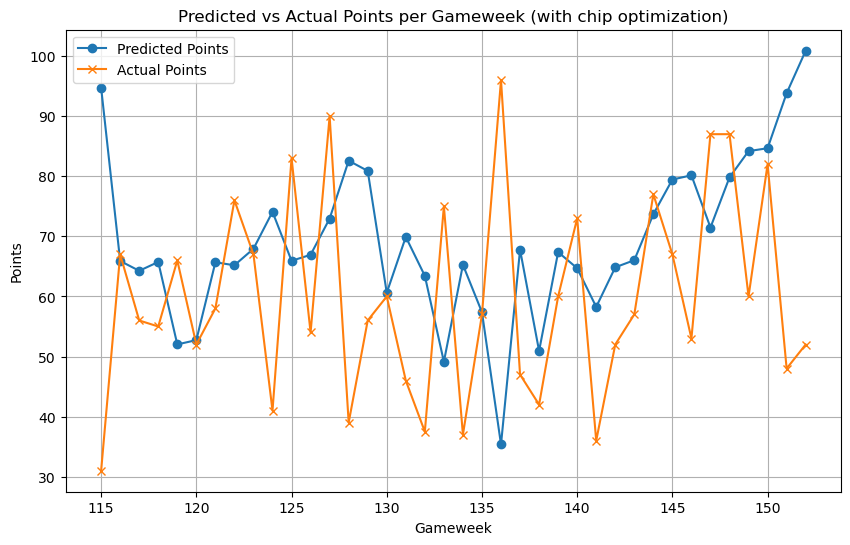

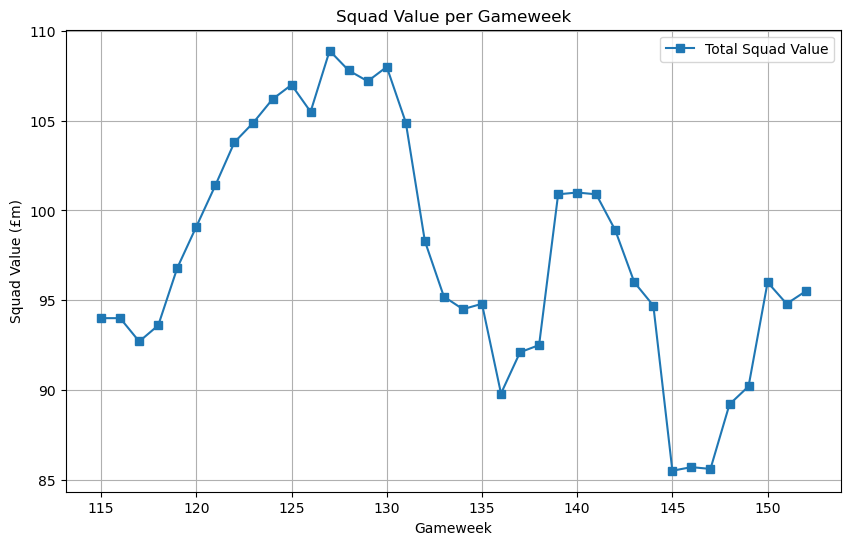

In [238]:
import pandas as pd
import matplotlib.pyplot as plt

def ensure_unique_player_id(data):
    if 'unique_player_id' not in data.columns:
        data['unique_player_id'] = data['name'] + '_' + data['team'] + '_GW' + data['GW'].astype(str)
    return data

def remove_duplicate_players(gw_data):
    gw_data = ensure_unique_player_id(gw_data)
    gw_data = gw_data.sort_values('Predicted_Points', ascending=False)
    return gw_data.drop_duplicates(subset=['unique_player_id'], keep='first')

def update_player_ids(starting_11, bench, gw):
    updated_starting_11 = [p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in starting_11]
    updated_bench = [p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in bench]
    return updated_starting_11, updated_bench

def fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=None):
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))

    for bench_player in current_bench.copy():
        if bench_player in predicted_points:
            bench_position = position_mapping[bench_player]
            for starting_player in current_starting_11.copy():
                if starting_player in predicted_points:
                    starting_position = position_mapping[starting_player]
                    if bench_position == starting_position and predicted_points[bench_player] > predicted_points[starting_player]:
                        print(f"Substituting {starting_player} with {bench_player} from the bench")
                        current_starting_11.remove(starting_player)
                        current_starting_11.append(bench_player)
                        current_bench.remove(bench_player)
                        current_bench.append(starting_player)
                        break
    return current_starting_11, current_bench

def assign_captain_and_vice_captain(starting_11, gw_data):
    starting_players_data = gw_data[gw_data['unique_player_id'].isin(starting_11)]
    sorted_players = starting_players_data.sort_values('Predicted_Points', ascending=False)
    captain = sorted_players.iloc[0]['unique_player_id']
    vice_captain = sorted_players.iloc[1]['unique_player_id']
    print(f"Captain: {captain}, Vice-Captain: {vice_captain}")
    return captain, vice_captain

def fpl_optimizer_one_transfer_multi_gw(gw_data, current_starting_11, current_bench, all_gw_data, gw, lookahead_gws=5, budget_limit=100, formation=None):
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))
    transfer_made = False
    best_transfer_gain = 0
    best_transfer = None

    all_gw_data = ensure_unique_player_id(all_gw_data)

    def sum_predicted_points_over_gws(player_name, current_gw, lookahead_gws):
        future_gws = all_gw_data[
            (all_gw_data['name'] == player_name.split('_')[0]) &  
            (all_gw_data['GW'] >= current_gw) &
            (all_gw_data['GW'] < current_gw + lookahead_gws)
        ]
        return future_gws['Predicted_Points'].sum()

    for new_player in gw_data['unique_player_id']:
        new_position = position_mapping[new_player]
        new_player_name = new_player.split('_')[0]
        if new_player not in current_starting_11 and new_player not in current_bench:
            for old_player in current_starting_11:
                old_position = position_mapping[old_player]
                old_player_name = old_player.split('_')[0]
                if old_position == new_position:
                    old_player_sum_points = sum_predicted_points_over_gws(old_player_name, gw, lookahead_gws)
                    new_player_sum_points = sum_predicted_points_over_gws(new_player_name, gw, lookahead_gws)
                    predicted_points_gain = new_player_sum_points - old_player_sum_points
                    if predicted_points_gain > best_transfer_gain:
                        best_transfer_gain = predicted_points_gain
                        best_transfer = (new_player, old_player)

    if best_transfer:
        new_player, old_player = best_transfer
        current_starting_11.remove(old_player)
        current_starting_11.append(new_player)
        transfer_made = True
        print(f"Transferring OUT {old_player} and IN {new_player} for the next {lookahead_gws} GWs")

    return current_starting_11, current_bench, transfer_made

def optimize_chip_usage(gw_predictions, gw_actuals, total_squad_values, data, lookahead_gws, starting_11_data, bench_data):
    """
    Optimize chip usage based on predictions and actual points. 
    """
    chip_usage = {}

    # Handle empty case for gw_predictions
    if not gw_predictions:
        print("No gameweek predictions available for chip optimization.")
        return chip_usage

    # Free Hit - Find the gameweek with the highest predicted points
    max_predicted_gw = gw_predictions.index(max(gw_predictions)) + 115
    chip_usage['Free Hit'] = max_predicted_gw

    # Wildcard - Use it when a period of low scores is predicted
    avg_gw_points = [sum(gw_predictions[gw:gw + lookahead_gws]) / lookahead_gws for gw in range(0, len(gw_predictions) - lookahead_gws)]
    if avg_gw_points:
        min_avg_gw = avg_gw_points.index(min(avg_gw_points)) + 115
        chip_usage['Wildcard'] = min_avg_gw
    else:
        print("Not enough data for Wildcard optimization.")

    # Bench Boost - When bench is expected to score high
    bench_points = []
    for gw in range(115, 153):
        current_gw_bench = bench_data.get(gw, [])
        gw_bench_points = data[(data['GW'] == gw) & (data['unique_player_id'].isin(current_gw_bench))]['Predicted_Points'].sum()
        bench_points.append(gw_bench_points)

    if bench_points:
        max_bench_gw = bench_points.index(max(bench_points)) + 115
        chip_usage['Bench Boost'] = max_bench_gw
    else:
        print("Not enough data for Bench Boost optimization.")

    # Triple Captain - Use it on the player with the highest predicted points over the season
    triple_captain_gws = data[data['GW'].between(115, 152)]
    
    if not triple_captain_gws.empty and 'Predicted_Points' in triple_captain_gws.columns:
        max_predicted_points = triple_captain_gws['Predicted_Points'].max()
        max_triple_captain_player = triple_captain_gws[triple_captain_gws['Predicted_Points'] == max_predicted_points].iloc[0]
        chip_usage['Triple Captain'] = max_triple_captain_player['GW']
    else:
        print("Not enough data for Triple Captain optimization.")
        chip_usage['Triple Captain'] = max_predicted_gw  # Fallback to using the highest predicted GW

    return chip_usage


def simulate_full_season_with_chips(data, initial_starting_11, initial_bench, free_transfers=1, max_transfers=5, transfer_cost=4, formation=None, lookahead_gws=5):
    """
    Simulates the FPL season from GW 115 to 152, managing transfers, bench substitutions, points for each GW,
    and optimizing chip usage (Free Hit, Wildcard, Bench Boost, Triple Captain).
    """
    total_predicted_points = 0
    total_actual_points = 0
    total_value = 0
    transfer_bank = free_transfers
    current_starting_11 = initial_starting_11.copy()
    current_bench = initial_bench.copy()
    original_starting_11 = initial_starting_11.copy()  # To revert after Free Hit
    wildcard_applied = False

    # Track bench and starting 11 for each GW
    bench_data = {}
    starting_11_data = {}

    gw_predictions = []
    gw_actuals = []
    gw_values = []

    for gw in range(115, 153):
        gw_data = data[data['GW'] == gw].copy()
        gw_data = remove_duplicate_players(gw_data)

        current_starting_11, current_bench = update_player_ids(current_starting_11, current_bench, gw)

        current_starting_11 = [p for p in current_starting_11 if p in gw_data['unique_player_id'].values]
        current_bench = [p for p in current_bench if p in gw_data['unique_player_id'].values]

        # Substituting better bench players before making transfers
        current_starting_11, current_bench = fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=formation)

        # Assign captain and vice-captain
        captain, vice_captain = assign_captain_and_vice_captain(current_starting_11, gw_data)

        # Calculate predicted and actual points for the current gameweek
        current_predicted_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['Predicted_Points'].sum()
        current_actual_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['next_GW_total_points'].sum()

        # Double the captain's points
        if captain in gw_data['unique_player_id'].values:
            current_predicted_points += gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]
            current_actual_points += gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]

        # Calculate the total squad value (starting 11 + bench)
        total_squad_value = gw_data[gw_data['unique_player_id'].isin(current_starting_11 + current_bench)]['value'].sum()

        # Optionally make transfers as needed, update transfer bank
        transfer_made = False
        if transfer_bank > 0:
            for _ in range(min(transfer_bank, max_transfers)):
                final_starting_11, final_bench, made_transfer = fpl_optimizer_one_transfer_multi_gw(
                    gw_data, current_starting_11, current_bench, data, gw, lookahead_gws=lookahead_gws, formation=formation)
                current_starting_11 = final_starting_11
                current_bench = final_bench
                if made_transfer:
                    transfer_bank -= 1
                    transfer_made = True

        if not transfer_made:
            transfer_bank = min(transfer_bank + 1, 2)
        else:
            transfer_bank = 1

        # Print results for each GW
        print(f"\nGameweek {gw} - Starting 11:")
        print(gw_data[gw_data['unique_player_id'].isin(current_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])
        print(f"Bench for GW {gw}:")
        print(gw_data[gw_data['unique_player_id'].isin(current_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

        # Update total points and value
        total_predicted_points += current_predicted_points
        total_actual_points += current_actual_points
        total_value += total_squad_value

        # Collect data for chart and optimization
        gw_predictions.append(current_predicted_points)
        gw_actuals.append(current_actual_points)
        gw_values.append(total_squad_value)

        print(f"Total Predicted Points for GW {gw}: {current_predicted_points}")
        print(f"Total Actual Points for GW {gw}: {current_actual_points}")
        print(f"Total Squad Value for GW {gw}: {total_squad_value}")

    # Optimize chip usage at the end of the season
    chip_usage = optimize_chip_usage(gw_predictions, gw_actuals, gw_values, data, lookahead_gws=lookahead_gws, starting_11_data=starting_11_data, bench_data=bench_data)

    # Ensure Free Hit is not used in the first GW
    if 'Free Hit' in chip_usage and chip_usage['Free Hit'] == 115:
        print("Skipping Free Hit in the first GW")
        del chip_usage['Free Hit']

    # Apply Wildcard logic
    if 'Wildcard' in chip_usage and not wildcard_applied:
        if gw == chip_usage['Wildcard']:
            print(f"Applying Wildcard in GW {gw}")
            wildcard_squad = gw_data.sort_values('Predicted_Points', ascending=False).head(len(current_starting_11 + current_bench))
            current_starting_11 = list(wildcard_squad['unique_player_id'].head(len(current_starting_11)))
            current_bench = list(wildcard_squad['unique_player_id'].tail(len(current_bench)))
            wildcard_applied = True  # Wildcard only gets applied once

    # Apply Free Hit logic
    if 'Free Hit' in chip_usage:
        if gw == chip_usage.get('Free Hit'):
            print(f"Applying Free Hit in GW {gw}")
            free_hit_squad = gw_data.sort_values('Predicted_Points', ascending=False).head(len(current_starting_11 + current_bench))
            current_starting_11 = list(free_hit_squad['unique_player_id'].head(len(current_starting_11)))
            current_bench = list(free_hit_squad['unique_player_id'].tail(len(current_bench)))
        elif gw == chip_usage.get('Free Hit') + 1:
            print(f"Reverting Free Hit after GW {gw}")
            current_starting_11 = original_starting_11  # Revert to original squad

    return total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage


def plot_results(gw_predictions, gw_actuals, gw_values):
    """
    Plots the predicted vs actual points per gameweek and the squad value throughout the season.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_predictions, label='Predicted Points', marker='o')
    plt.plot(range(115, 153), gw_actuals, label='Actual Points', marker='x')
    plt.xlabel('Gameweek')
    plt.ylabel('Points')
    plt.title('Predicted vs Actual Points per Gameweek (with chip optimization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_values, label='Total Squad Value', marker='s')
    plt.xlabel('Gameweek')
    plt.ylabel('Squad Value (£m)')
    plt.title('Squad Value per Gameweek')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulate the full season with chip optimization
total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage = simulate_full_season_with_chips(
    data, initial_starting_11, initial_bench, lookahead_gws=5)

# Output the total points and chip usage
print(f"\nTotal Predicted Points for the full season: {total_predicted_points}")
print(f"Total Actual Points for the full season: {total_actual_points}")
print(f"Optimized Chip Usage: {chip_usage}")

# Plot the comparison chart for predicted and actual points
plot_results(gw_predictions, gw_actuals, gw_values)

Captain: erling haaland_Man City_GW115, Vice-Captain: callum wilson_Newcastle_GW115
Transferring OUT nelson cabral semedo_Wolves_GW115 and IN destiny udogie_Spurs_GW115 for the next 5 GWs

Gameweek 115 - Starting 11:
                   name            team position  Predicted_Points  \
47769    erling haaland        Man City      FWD         10.389618   
47476     callum wilson       Newcastle      FWD          9.557711   
48200     mohamed salah       Liverpool      MID          9.508635   
47639      eberechi eze  Crystal Palace      MID          9.433738   
48428       yoane wissa       Brentford      FWD          9.432960   
48203      moussa diaby     Aston Villa      MID          9.284191   
48264     sandro tonali       Newcastle      MID          9.014761   
47462        bernd leno          Fulham       GK          7.879585   
47409       axel disasi         Chelsea      DEF          7.252136   
47842  joachim andersen  Crystal Palace      DEF          1.303292   
47631    dest

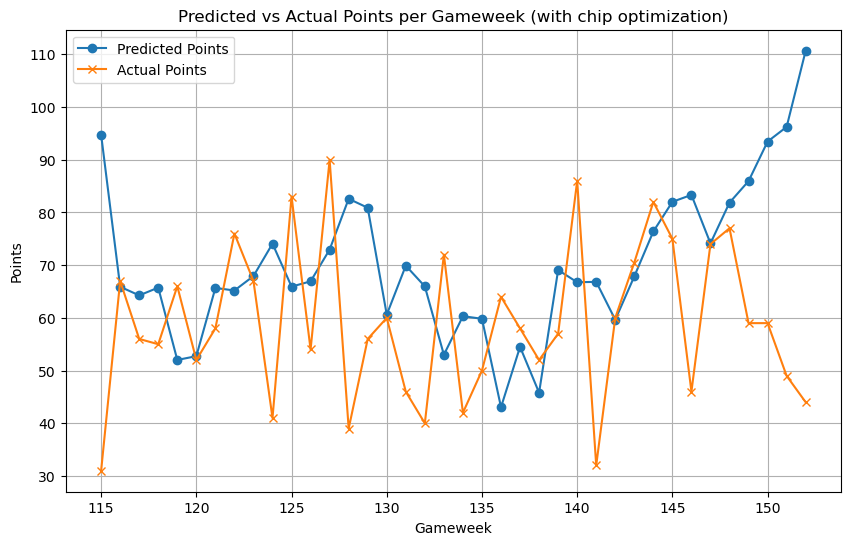

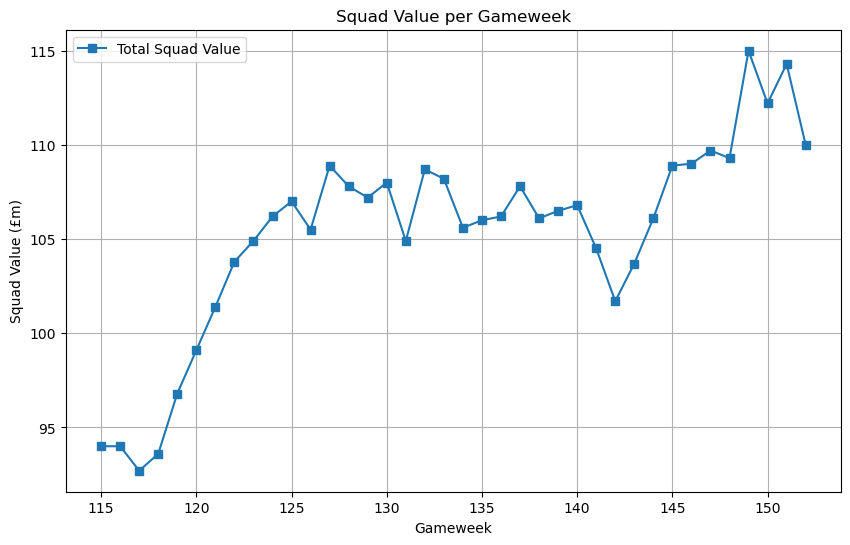

In [240]:
import pandas as pd
import matplotlib.pyplot as plt

def ensure_unique_player_id(data):
    if 'unique_player_id' not in data.columns:
        data['unique_player_id'] = data['name'] + '_' + data['team'] + '_GW' + data['GW'].astype(str)
    return data

def remove_duplicate_players(gw_data):
    gw_data = ensure_unique_player_id(gw_data)
    gw_data = gw_data.sort_values('Predicted_Points', ascending=False)
    return gw_data.drop_duplicates(subset=['unique_player_id'], keep='first')

def update_player_ids(starting_11, bench, gw):
    updated_starting_11 = [p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in starting_11]
    updated_bench = [p.replace(f'_GW{gw-1}', f'_GW{gw}') for p in bench]
    return updated_starting_11, updated_bench

def fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=None):
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))

    for bench_player in current_bench.copy():
        if bench_player in predicted_points:
            bench_position = position_mapping[bench_player]
            for starting_player in current_starting_11.copy():
                if starting_player in predicted_points:
                    starting_position = position_mapping[starting_player]
                    if bench_position == starting_position and predicted_points[bench_player] > predicted_points[starting_player]:
                        print(f"Substituting {starting_player} with {bench_player} from the bench")
                        current_starting_11.remove(starting_player)
                        current_starting_11.append(bench_player)
                        current_bench.remove(bench_player)
                        current_bench.append(starting_player)
                        break
    return current_starting_11, current_bench

def assign_captain_and_vice_captain(starting_11, gw_data):
    starting_players_data = gw_data[gw_data['unique_player_id'].isin(starting_11)]
    sorted_players = starting_players_data.sort_values('Predicted_Points', ascending=False)
    captain = sorted_players.iloc[0]['unique_player_id']
    vice_captain = sorted_players.iloc[1]['unique_player_id']
    print(f"Captain: {captain}, Vice-Captain: {vice_captain}")
    return captain, vice_captain

def fpl_optimizer_one_transfer_multi_gw(gw_data, current_starting_11, current_bench, all_gw_data, gw, lookahead_gws=5, budget_limit=100, formation=None):
    predicted_points = dict(zip(gw_data['unique_player_id'], gw_data['Predicted_Points']))
    position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))
    transfer_made = False
    best_transfer_gain = 0
    best_transfer = None

    all_gw_data = ensure_unique_player_id(all_gw_data)

    def sum_predicted_points_over_gws(player_name, current_gw, lookahead_gws):
        future_gws = all_gw_data[
            (all_gw_data['name'] == player_name.split('_')[0]) &  
            (all_gw_data['GW'] >= current_gw) &
            (all_gw_data['GW'] < current_gw + lookahead_gws)
        ]
        return future_gws['Predicted_Points'].sum()

    for new_player in gw_data['unique_player_id']:
        new_position = position_mapping[new_player]
        new_player_name = new_player.split('_')[0]
        if new_player not in current_starting_11 and new_player not in current_bench:
            for old_player in current_starting_11:
                old_position = position_mapping[old_player]
                old_player_name = old_player.split('_')[0]
                if old_position == new_position:
                    old_player_sum_points = sum_predicted_points_over_gws(old_player_name, gw, lookahead_gws)
                    new_player_sum_points = sum_predicted_points_over_gws(new_player_name, gw, lookahead_gws)
                    predicted_points_gain = new_player_sum_points - old_player_sum_points
                    if predicted_points_gain > best_transfer_gain:
                        best_transfer_gain = predicted_points_gain
                        best_transfer = (new_player, old_player)

    if best_transfer:
        new_player, old_player = best_transfer
        current_starting_11.remove(old_player)
        current_starting_11.append(new_player)
        transfer_made = True
        print(f"Transferring OUT {old_player} and IN {new_player} for the next {lookahead_gws} GWs")

    return current_starting_11, current_bench, transfer_made

def optimize_chip_usage(gw_predictions, gw_actuals, total_squad_values, data, lookahead_gws, starting_11_data, bench_data):
    """
    Optimize chip usage based on predictions and actual points. 
    """
    chip_usage = {}

    # Handle empty case for gw_predictions
    if not gw_predictions:
        print("No gameweek predictions available for chip optimization.")
        return chip_usage

    # Free Hit - Find the gameweek with the highest predicted points
    max_predicted_gw = gw_predictions.index(max(gw_predictions)) + 115
    chip_usage['Free Hit'] = max_predicted_gw

    # Wildcard - Use it when a period of low scores is predicted
    avg_gw_points = [sum(gw_predictions[gw:gw + lookahead_gws]) / lookahead_gws for gw in range(0, len(gw_predictions) - lookahead_gws)]
    if avg_gw_points:
        min_avg_gw = avg_gw_points.index(min(avg_gw_points)) + 115
        chip_usage['Wildcard'] = min_avg_gw
    else:
        print("Not enough data for Wildcard optimization.")

    # Bench Boost - When bench is expected to score high
    bench_points = []
    for gw in range(115, 153):
        current_gw_bench = bench_data.get(gw, [])
        gw_bench_points = data[(data['GW'] == gw) & (data['unique_player_id'].isin(current_gw_bench))]['Predicted_Points'].sum()
        bench_points.append(gw_bench_points)

    if bench_points:
        max_bench_gw = bench_points.index(max(bench_points)) + 115
        chip_usage['Bench Boost'] = max_bench_gw
    else:
        print("Not enough data for Bench Boost optimization.")

    # Triple Captain - Use it on the player with the highest predicted points over the season
    triple_captain_gws = data[data['GW'].between(115, 152)]
    
    if not triple_captain_gws.empty and 'Predicted_Points' in triple_captain_gws.columns:
        max_predicted_points = triple_captain_gws['Predicted_Points'].max()
        max_triple_captain_player = triple_captain_gws[triple_captain_gws['Predicted_Points'] == max_predicted_points].iloc[0]
        chip_usage['Triple Captain'] = max_triple_captain_player['GW']
    else:
        print("Not enough data for Triple Captain optimization.")
        chip_usage['Triple Captain'] = max_predicted_gw  # Fallback to using the highest predicted GW

    return chip_usage


def simulate_full_season_with_chips(data, initial_starting_11, initial_bench, free_transfers=1, max_transfers=5, transfer_cost=4, formation=None, lookahead_gws=5):
    """
    Simulates the FPL season from GW 115 to 152, managing transfers, bench substitutions, points for each GW,
    and optimizing chip usage (Free Hit, Wildcard, Bench Boost, Triple Captain).
    """
    total_predicted_points = 0
    total_actual_points = 0
    total_value = 0
    transfer_bank = free_transfers
    current_starting_11 = initial_starting_11.copy()
    current_bench = initial_bench.copy()
    original_starting_11 = initial_starting_11.copy()  # To revert after Free Hit
    original_bench = initial_bench.copy()  # To revert after Free Hit
    wildcard_applied = False

    # Track bench and starting 11 for each GW
    bench_data = {}
    starting_11_data = {}

    gw_predictions = []
    gw_actuals = []
    gw_values = []

    for gw in range(115, 153):
        gw_data = data[data['GW'] == gw].copy()
        gw_data = remove_duplicate_players(gw_data)

        current_starting_11, current_bench = update_player_ids(current_starting_11, current_bench, gw)

        current_starting_11 = [p for p in current_starting_11 if p in gw_data['unique_player_id'].values]
        current_bench = [p for p in current_bench if p in gw_data['unique_player_id'].values]

        # Apply Wildcard (permanent squad change)
        if 'Wildcard' in chip_usage and not wildcard_applied and gw == chip_usage['Wildcard']:
            print(f"Applying Wildcard in GW {gw}")
            wildcard_squad = gw_data.sort_values('Predicted_Points', ascending=False).head(len(current_starting_11 + current_bench))
            current_starting_11 = list(wildcard_squad['unique_player_id'].head(len(current_starting_11)))
            current_bench = list(wildcard_squad['unique_player_id'].tail(len(current_bench)))
            wildcard_applied = True  # Wildcard only gets applied once

        # Apply Free Hit (temporary squad change)
        if 'Free Hit' in chip_usage and gw == chip_usage['Free Hit']:
            print(f"Applying Free Hit in GW {gw}")
            free_hit_squad = gw_data.sort_values('Predicted_Points', ascending=False).head(len(current_starting_11 + current_bench))
            current_starting_11 = list(free_hit_squad['unique_player_id'].head(len(current_starting_11)))
            current_bench = list(free_hit_squad['unique_player_id'].tail(len(current_bench)))
        elif 'Free Hit' in chip_usage and gw == chip_usage['Free Hit'] + 1:
            # Revert squad after Free Hit
            print(f"Reverting Free Hit after GW {gw}")
            current_starting_11 = original_starting_11.copy()
            current_bench = original_bench.copy()

        # Substituting better bench players before making transfers
        current_starting_11, current_bench = fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=formation)

        # Assign captain and vice-captain
        captain, vice_captain = assign_captain_and_vice_captain(current_starting_11, gw_data)

        # Calculate predicted and actual points for the current gameweek
        current_predicted_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['Predicted_Points'].sum()
        current_actual_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['next_GW_total_points'].sum()

        # Double the captain's points
        if captain in gw_data['unique_player_id'].values:
            current_predicted_points += gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]
            current_actual_points += gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]

        # Calculate the total squad value (starting 11 + bench)
        total_squad_value = gw_data[gw_data['unique_player_id'].isin(current_starting_11 + current_bench)]['value'].sum()

        # Optionally make transfers as needed, update transfer bank
        transfer_made = False
        if transfer_bank > 0:
            for _ in range(min(transfer_bank, max_transfers)):
                final_starting_11, final_bench, made_transfer = fpl_optimizer_one_transfer_multi_gw(
                    gw_data, current_starting_11, current_bench, data, gw, lookahead_gws=lookahead_gws, formation=formation)
                current_starting_11 = final_starting_11
                current_bench = final_bench
                if made_transfer:
                    transfer_bank -= 1
                    transfer_made = True

        if not transfer_made:
            transfer_bank = min(transfer_bank + 1, 2)
        else:
            transfer_bank = 1

        # Print results for each GW
        print(f"\nGameweek {gw} - Starting 11:")
        print(gw_data[gw_data['unique_player_id'].isin(current_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])
        print(f"Bench for GW {gw}:")
        print(gw_data[gw_data['unique_player_id'].isin(current_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

        # Update total points and value
        total_predicted_points += current_predicted_points
        total_actual_points += current_actual_points
        total_value += total_squad_value

        # Collect data for chart and optimization
        gw_predictions.append(current_predicted_points)
        gw_actuals.append(current_actual_points)
        gw_values.append(total_squad_value)

        print(f"Total Predicted Points for GW {gw}: {current_predicted_points}")
        print(f"Total Actual Points for GW {gw}: {current_actual_points}")
        print(f"Total Squad Value for GW {gw}: {total_squad_value}")

    return total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage


def plot_results(gw_predictions, gw_actuals, gw_values):
    """
    Plots the predicted vs actual points per gameweek and the squad value throughout the season.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_predictions, label='Predicted Points', marker='o')
    plt.plot(range(115, 153), gw_actuals, label='Actual Points', marker='x')
    plt.xlabel('Gameweek')
    plt.ylabel('Points')
    plt.title('Predicted vs Actual Points per Gameweek (with chip optimization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_values, label='Total Squad Value', marker='s')
    plt.xlabel('Gameweek')
    plt.ylabel('Squad Value (£m)')
    plt.title('Squad Value per Gameweek')
    plt.legend()
    plt.grid(True)
    plt.show()


# Simulate the full season with chip optimization
total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage = simulate_full_season_with_chips(
    data, initial_starting_11, initial_bench, lookahead_gws=5)

# Output the total points and chip usage
print(f"\nTotal Predicted Points for the full season: {total_predicted_points}")
print(f"Total Actual Points for the full season: {total_actual_points}")
print(f"Optimized Chip Usage: {chip_usage}")

# Plot the comparison chart for predicted and actual points
plot_results(gw_predictions, gw_actuals, gw_values)



Captain: erling haaland_Man City_GW115, Vice-Captain: callum wilson_Newcastle_GW115
Transferring OUT nelson cabral semedo_Wolves_GW115 and IN destiny udogie_Spurs_GW115 for the next 5 GWs

Gameweek 115 - Starting 11:
                   name            team position  Predicted_Points  \
47769    erling haaland        Man City      FWD         10.389618   
47476     callum wilson       Newcastle      FWD          9.557711   
48200     mohamed salah       Liverpool      MID          9.508635   
47639      eberechi eze  Crystal Palace      MID          9.433738   
48428       yoane wissa       Brentford      FWD          9.432960   
48203      moussa diaby     Aston Villa      MID          9.284191   
48264     sandro tonali       Newcastle      MID          9.014761   
47462        bernd leno          Fulham       GK          7.879585   
47409       axel disasi         Chelsea      DEF          7.252136   
47842  joachim andersen  Crystal Palace      DEF          1.303292   
47631    dest

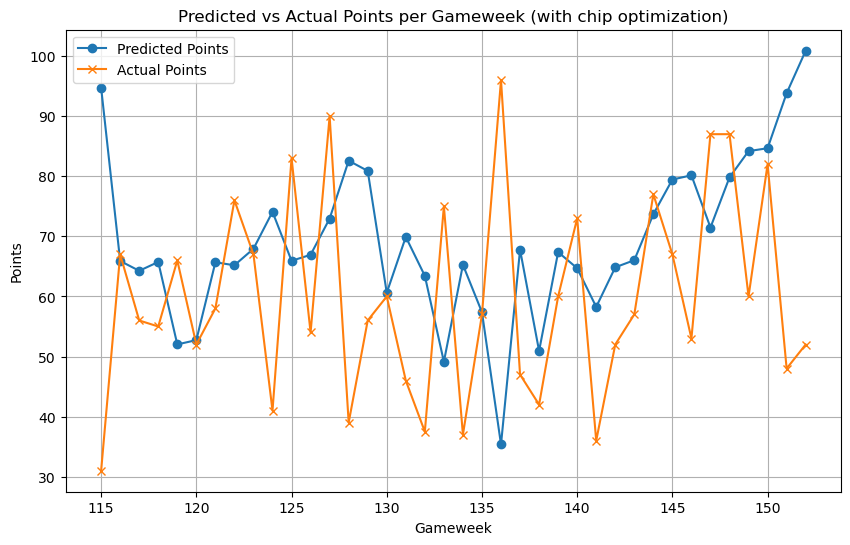

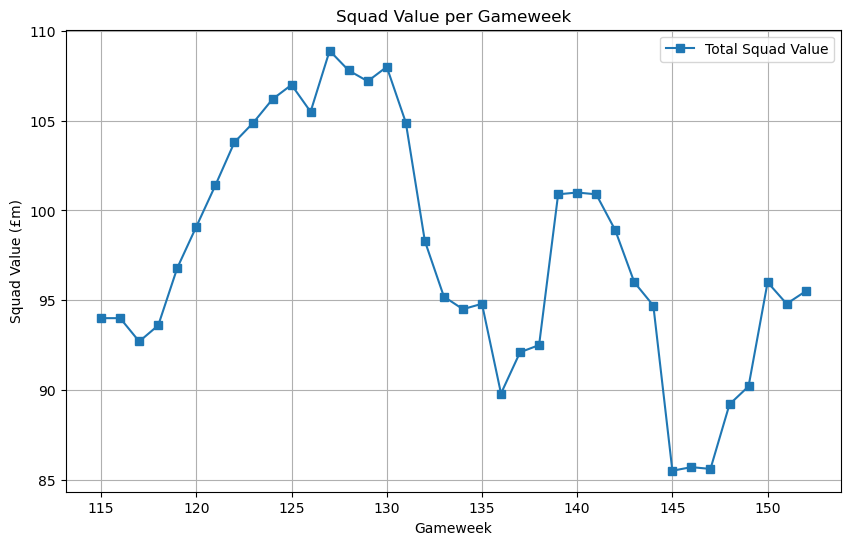

In [250]:
import pandas as pd
import matplotlib.pyplot as plt

def apply_formation_constraints(gw_data, formation, num_def=3, num_mid=4, num_fwd=3):
    """
    Apply the formation constraints on the squad selection after Wildcard or Free Hit is applied.
    Ensure the squad has the correct number of DEF, MID, FWD players.
    """
    goalkeepers = gw_data[gw_data['position'] == 'GK'].sort_values('Predicted_Points', ascending=False).head(1)
    defenders = gw_data[gw_data['position'] == 'DEF'].sort_values('Predicted_Points', ascending=False).head(num_def)
    midfielders = gw_data[gw_data['position'] == 'MID'].sort_values('Predicted_Points', ascending=False).head(num_mid)
    forwards = gw_data[gw_data['position'] == 'FWD'].sort_values('Predicted_Points', ascending=False).head(num_fwd)

    # Combine to form the squad following the formation rules
    squad = pd.concat([goalkeepers, defenders, midfielders, forwards])
    return squad

def simulate_full_season_with_chips(data, initial_starting_11, initial_bench, free_transfers=1, max_transfers=5, transfer_cost=4, formation=None, lookahead_gws=5):
    """
    Simulates the FPL season from GW 115 to 152, managing transfers, bench substitutions, points for each GW,
    and optimizing chip usage (Free Hit, Wildcard, Bench Boost, Triple Captain).
    """
    total_predicted_points = 0
    total_actual_points = 0
    total_value = 0
    transfer_bank = free_transfers
    current_starting_11 = initial_starting_11.copy()
    current_bench = initial_bench.copy()
    original_starting_11 = initial_starting_11.copy()  # To revert after Free Hit
    original_bench = initial_bench.copy()  # To revert after Free Hit
    wildcard_applied = False

    # Track bench and starting 11 for each GW
    bench_data = {}
    starting_11_data = {}

    gw_predictions = []
    gw_actuals = []
    gw_values = []

    for gw in range(115, 153):
        gw_data = data[data['GW'] == gw].copy()
        gw_data = remove_duplicate_players(gw_data)

        current_starting_11, current_bench = update_player_ids(current_starting_11, current_bench, gw)

        current_starting_11 = [p for p in current_starting_11 if p in gw_data['unique_player_id'].values]
        current_bench = [p for p in current_bench if p in gw_data['unique_player_id'].values]

        # Substituting better bench players before making transfers
        current_starting_11, current_bench = fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation=formation)

        # Assign captain and vice-captain
        captain, vice_captain = assign_captain_and_vice_captain(current_starting_11, gw_data)

        # Calculate predicted and actual points for the current gameweek
        current_predicted_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['Predicted_Points'].sum()
        current_actual_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['next_GW_total_points'].sum()

        # Double the captain's points for both predicted and actual points
        if captain in gw_data['unique_player_id'].values:
            current_predicted_points += gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]  # Add captain's predicted points again (double)
            current_actual_points += gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]  # Add captain's actual points again (double)

        # Calculate the total squad value (starting 11 + bench)
        total_squad_value = gw_data[gw_data['unique_player_id'].isin(current_starting_11 + current_bench)]['value'].sum()

        # Optionally make transfers as needed, update transfer bank
        transfer_made = False
        if transfer_bank > 0:
            for _ in range(min(transfer_bank, max_transfers)):
                final_starting_11, final_bench, made_transfer = fpl_optimizer_one_transfer_multi_gw(
                    gw_data, current_starting_11, current_bench, data, gw, lookahead_gws=lookahead_gws, formation=formation)
                current_starting_11 = final_starting_11
                current_bench = final_bench
                if made_transfer:
                    transfer_bank -= 1
                    transfer_made = True

        if not transfer_made:
            transfer_bank = min(transfer_bank + 1, 2)
        else:
            transfer_bank = 1

        # Print results for each GW
        print(f"\nGameweek {gw} - Starting 11:")
        print(gw_data[gw_data['unique_player_id'].isin(current_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])
        print(f"Bench for GW {gw}:")
        print(gw_data[gw_data['unique_player_id'].isin(current_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

        # Update total points and value
        total_predicted_points += current_predicted_points
        total_actual_points += current_actual_points
        total_value += total_squad_value

        # Collect data for chart and optimization
        gw_predictions.append(current_predicted_points)
        gw_actuals.append(current_actual_points)
        gw_values.append(total_squad_value)

        print(f"Total Predicted Points for GW {gw}: {current_predicted_points}")
        print(f"Total Actual Points for GW {gw}: {current_actual_points}")
        print(f"Total Squad Value for GW {gw}: {total_squad_value}")

    return total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage

def plot_results(gw_predictions, gw_actuals, gw_values):
    """
    Plots the predicted vs actual points per gameweek and the squad value throughout the season.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_predictions, label='Predicted Points', marker='o')
    plt.plot(range(115, 153), gw_actuals, label='Actual Points', marker='x')
    plt.xlabel('Gameweek')
    plt.ylabel('Points')
    plt.title('Predicted vs Actual Points per Gameweek (with chip optimization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_values, label='Total Squad Value', marker='s')
    plt.xlabel('Gameweek')
    plt.ylabel('Squad Value (£m)')
    plt.title('Squad Value per Gameweek')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assume data, initial_starting_11, and initial_bench are defined elsewhere
    total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage = simulate_full_season_with_chips(
        data, initial_starting_11, initial_bench, lookahead_gws=5)

    # Output the total points and chip usage
    print(f"\nTotal Predicted Points for the full season: {total_predicted_points}")
    print(f"Total Actual Points for the full season: {total_actual_points}")
    print(f"Optimized Chip Usage: {chip_usage}")

    # Plot the comparison chart for predicted and actual points
    plot_results(gw_predictions, gw_actuals, gw_values)


Processing Gameweek 115
Number of players in position_mapping: 412
Sample of position_mapping: [('erling haaland_Man City_GW115', 'FWD'), ('callum wilson_Newcastle_GW115', 'FWD'), ('mohamed salah_Liverpool_GW115', 'MID'), ('eberechi eze_Crystal Palace_GW115', 'MID'), ('yoane wissa_Brentford_GW115', 'FWD')]


C:\Users\syeds\AppData\Local\Temp\ipykernel_2464\4212615013.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['unique_player_id'] = data['name'] + '_' + data['team'] + '_GW' + data['GW'].astype(str)


Transferring OUT nelson cabral semedo_Wolves_GW115 and IN destiny udogie_Spurs_GW115 for the next 5 GWs
Captain: erling haaland_Man City_GW115, Vice-Captain: callum wilson_Newcastle_GW115

Gameweek 115 - Starting 11:
                   name            team position  Predicted_Points  \
47769    erling haaland        Man City      FWD         10.389618   
47476     callum wilson       Newcastle      FWD          9.557711   
48200     mohamed salah       Liverpool      MID          9.508635   
47639      eberechi eze  Crystal Palace      MID          9.433738   
48428       yoane wissa       Brentford      FWD          9.432960   
48203      moussa diaby     Aston Villa      MID          9.284191   
48264     sandro tonali       Newcastle      MID          9.014761   
47462        bernd leno          Fulham       GK          7.879585   
47409       axel disasi         Chelsea      DEF          7.252136   
47842  joachim andersen  Crystal Palace      DEF          1.303292   
47631    dest

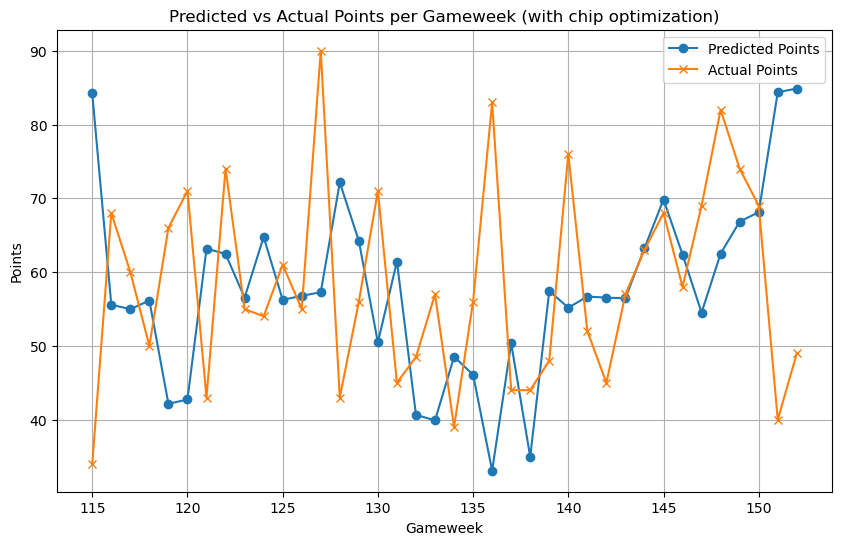

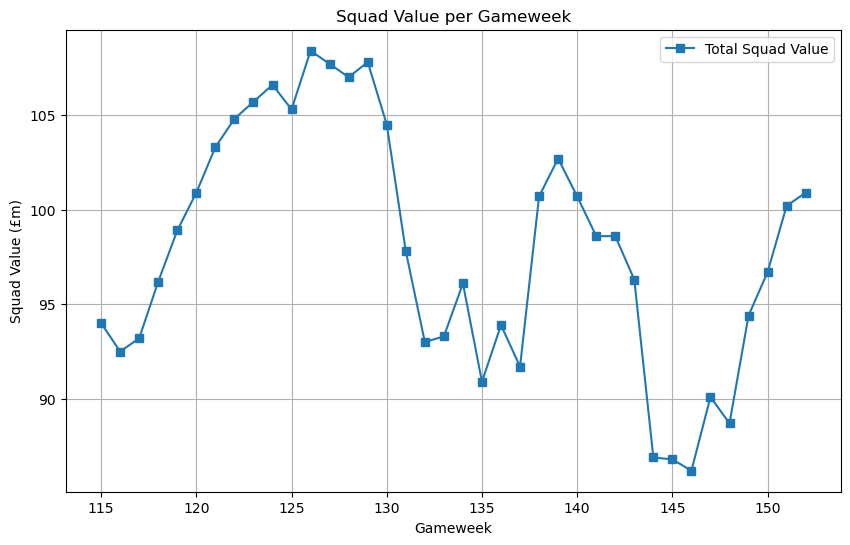

In [345]:

def update_player_ids(starting_11, bench, current_gw):
    def update_id(player_id):
        parts = player_id.split('_')
        parts[-1] = f"GW{current_gw}"
        return '_'.join(parts)
    
    updated_starting_11 = [update_id(player) for player in starting_11]
    updated_bench = [update_id(player) for player in bench]
    
    return updated_starting_11, updated_bench

def manually_input_team(gw):
    if gw == 141:  # Free Hit in GW 141
        starting_11 = [
            'andre onana_Man Utd_GW141', 'benjamin white_Arsenal_GW141', 'gabriel dos santos magalhaes_Arsenal_GW141', 'kieran trippier_Newcastle_GW141',
            'bukayo saka_Arsenal_GW141','cole palmer_Chelsea_GW141', 'phil foden_Man City_GW141', 'richarlison de andrade_Spurs_GW141',
            'erling haaland_Man City_GW141', 'nicolas jackson_Chelsea_GW141' , 'ollie watkins_Aston Villa_GW141'
        ]
        bench = [
            'stefan ortega moreno_Man City_GW141', 'kortney hause_Aston Villa_GW141', 'tariq lamptey_Brighton_GW141', 'elliot anderson_Newcastle_GW141'
        ]
    elif gw == 132:  # Wildcard in GW 132
        starting_11 = [
            'alphonse areola_West Ham_GW132', 'james tarkowski_Everton_GW132', 'kieran trippier_Newcastle_GW132',
            'trent alexander arnold_Liverpool_GW132', 'bernardo veiga de carvalho e silva_Man City_GW132', 
            'cole palmer_Chelsea_GW132', 'mohamed salah_Liverpool_GW132', 'mohammed kudus_West Ham_GW132', 
            'julian alvarez_Man City_GW132', 'matheus santos carneiro da cunha_Wolves_GW132', 'ollie watkins_Aston Villa_GW132'
        ]
        bench = [
            'caoimhin kelleher_Liverpool_GW132', 'kortney hause_Aston Villa_GW132', 'alex murphy_Newcastle_GW132', 'facundo pellistri rebollo_Man Utd_GW132'
        ]
    else:
        raise ValueError("Manual input only allowed for Free Hit (GW 115) or Wildcard (GW 132).")
    
    return starting_11, bench

def adjust_formation(starting_11, bench, position_mapping):
    def get_player_from_bench(position):
        return next((player for player in bench if position_mapping[player] == position), None)
    
    def get_player_from_starting(position):
        return next((player for player in starting_11 if position_mapping[player] == position), None)
    
    while not is_valid_formation(starting_11, position_mapping):
        positions = [position_mapping[player] for player in starting_11]
        gk_count = positions.count('GK')
        def_count = positions.count('DEF')
        mid_count = positions.count('MID')
        fwd_count = positions.count('FWD')
        
        if gk_count > 1:
            extra_gk = get_player_from_starting('GK')
            starting_11.remove(extra_gk)
            bench.append(extra_gk)
            bench_gk = get_player_from_bench('GK')
            if bench_gk:
                starting_11.append(bench_gk)
                bench.remove(bench_gk)
        elif def_count < 3:
            bench_def = get_player_from_bench('DEF')
            if bench_def:
                starting_11.append(bench_def)
                bench.remove(bench_def)
                extra_player = get_player_from_starting('MID') or get_player_from_starting('FWD')
                if extra_player:
                    starting_11.remove(extra_player)
                    bench.append(extra_player)
        elif def_count > 5:
            extra_def = get_player_from_starting('DEF')
            starting_11.remove(extra_def)
            bench.append(extra_def)
            bench_player = get_player_from_bench('MID') or get_player_from_bench('FWD')
            if bench_player:
                starting_11.append(bench_player)
                bench.remove(bench_player)
        elif mid_count < 2:
            bench_mid = get_player_from_bench('MID')
            if bench_mid:
                starting_11.append(bench_mid)
                bench.remove(bench_mid)
                extra_player = get_player_from_starting('DEF') or get_player_from_starting('FWD')
                if extra_player:
                    starting_11.remove(extra_player)
                    bench.append(extra_player)
        elif fwd_count < 1:
            bench_fwd = get_player_from_bench('FWD')
            if bench_fwd:
                starting_11.append(bench_fwd)
                bench.remove(bench_fwd)
                extra_player = get_player_from_starting('DEF') or get_player_from_starting('MID')
                if extra_player:
                    starting_11.remove(extra_player)
                    bench.append(extra_player)
    
    return starting_11, bench

def simulate_full_season_with_chips(data, initial_starting_11, initial_bench, free_transfers=1, max_transfers=1, transfer_cost=4, formation=None, lookahead_gws=5):
    total_predicted_points = 0
    total_actual_points = 0
    gw_predictions = []
    gw_actuals = []
    gw_values = []
    
    current_starting_11 = initial_starting_11.copy()
    current_bench = initial_bench.copy()
    transfer_bank = free_transfers

    # Find best weeks for using chips
    wildcard_gw = 132  # Wildcard fixed for GW 132
    free_hit_gw = 141  # Free Hit fixed for GW 115
    # (You can add functions to dynamically find bench boost, triple captain if needed.)

    for gw in range(115, 153):
        print(f"\nProcessing Gameweek {gw}")
        
        # Update player IDs for the current gameweek
        current_starting_11, current_bench = update_player_ids(current_starting_11, current_bench, gw)
        
        gw_data = data[data['GW'] == gw]
        gw_data = remove_duplicate_players(gw_data)

        # Create position mapping
        position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))

        # Apply chips
        if gw == wildcard_gw:
            print(f"Using Wildcard in GW {gw}")
            current_starting_11, current_bench = manually_input_team(gw)  # Manually input the team for Wildcard
        elif gw == free_hit_gw:
            print(f"Using Free Hit in GW {gw}")
            current_starting_11, current_bench = manually_input_team(gw)  # Manually input the team for Free Hit
        else:
            # Handle transfers
            if transfer_bank > 0:
                for _ in range(min(transfer_bank, max_transfers)):
                    current_starting_11, current_bench, made_transfer = fpl_optimizer_one_transfer_multi_gw(
                        gw_data, current_starting_11, current_bench, data, gw, lookahead_gws=lookahead_gws, formation=formation)
                    if made_transfer:
                        transfer_bank -= 1
                    else:
                        break
            
            # Perform bench substitutions
            current_starting_11, current_bench = fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation)

        # Adjust formation if necessary
        current_starting_11, current_bench = adjust_formation(current_starting_11, current_bench, position_mapping)

        # Assign captain and vice-captain
        captain, vice_captain = assign_captain_and_vice_captain(current_starting_11, gw_data)

        # Calculate points for the gameweek
        starting_11_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['Predicted_Points'].sum()
        bench_points = gw_data[gw_data['unique_player_id'].isin(current_bench)]['Predicted_Points'].sum()
        
        current_predicted_points = starting_11_points
        current_actual_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['next_GW_total_points'].sum()
        total_squad_value = gw_data[gw_data['unique_player_id'].isin(current_starting_11 + current_bench)]['value'].sum()

        # Print gameweek information
        print(f"\nGameweek {gw} - Starting 11:")
        print(gw_data[gw_data['unique_player_id'].isin(current_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])
        print(f"Bench for GW {gw}:")
        print(gw_data[gw_data['unique_player_id'].isin(current_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

        # Update total points and store gameweek data
        total_predicted_points += current_predicted_points
        total_actual_points += current_actual_points
        gw_predictions.append(current_predicted_points)
        gw_actuals.append(current_actual_points)
        gw_values.append(total_squad_value)

        # Reset transfer bank and add free transfer for next gameweek
        transfer_bank = min(transfer_bank + free_transfers, 2)

        print(f"Predicted Points for GW {gw}: {current_predicted_points}")
        print(f"Actual Points for GW {gw}: {current_actual_points}")
        print(f"Total Squad Value: {total_squad_value}")

    return total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values

# Plotting results
def plot_results(gw_predictions, gw_actuals, gw_values):
    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_predictions, label='Predicted Points', marker='o')
    plt.plot(range(115, 153), gw_actuals, label='Actual Points', marker='x')
    plt.xlabel('Gameweek')
    plt.ylabel('Points')
    plt.title('Predicted vs Actual Points per Gameweek (with chip optimization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_values, label='Total Squad Value', marker='s')
    plt.xlabel('Gameweek')
    plt.ylabel('Squad Value (£m)')
    plt.title('Squad Value per Gameweek')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values = simulate_full_season_with_chips(
    data, initial_starting_11, initial_bench, lookahead_gws=5)

print(f"\nTotal Predicted Points for the full season: {total_predicted_points}")
print(f"Total Actual Points for the full season: {total_actual_points}")

# Plot the results
plot_results(gw_predictions, gw_actuals, gw_values)


Processing Gameweek 115
Number of players in position_mapping: 412
Sample of position_mapping: [('erling haaland_Man City_GW115', 'FWD'), ('callum wilson_Newcastle_GW115', 'FWD'), ('mohamed salah_Liverpool_GW115', 'MID'), ('eberechi eze_Crystal Palace_GW115', 'MID'), ('yoane wissa_Brentford_GW115', 'FWD')]
Transferring OUT nelson cabral semedo_Wolves_GW115 and IN destiny udogie_Spurs_GW115 for the next 5 GWs
Captain: erling haaland_Man City_GW115, Vice-Captain: callum wilson_Newcastle_GW115

Gameweek 115 - Starting 11:
                   name            team position  Predicted_Points  \
47769    erling haaland        Man City      FWD         10.389618   
47476     callum wilson       Newcastle      FWD          9.557711   
48200     mohamed salah       Liverpool      MID          9.508635   
47639      eberechi eze  Crystal Palace      MID          9.433738   
48428       yoane wissa       Brentford      FWD          9.432960   
48203      moussa diaby     Aston Villa      MID      

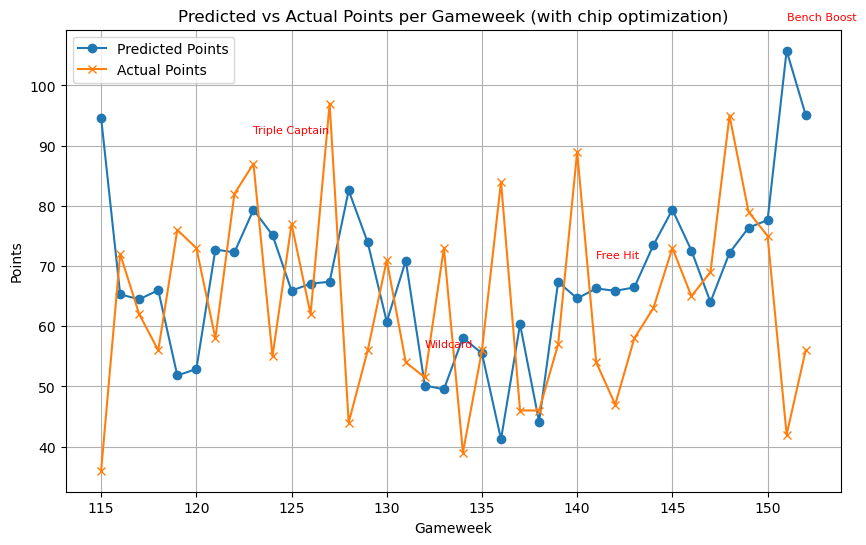

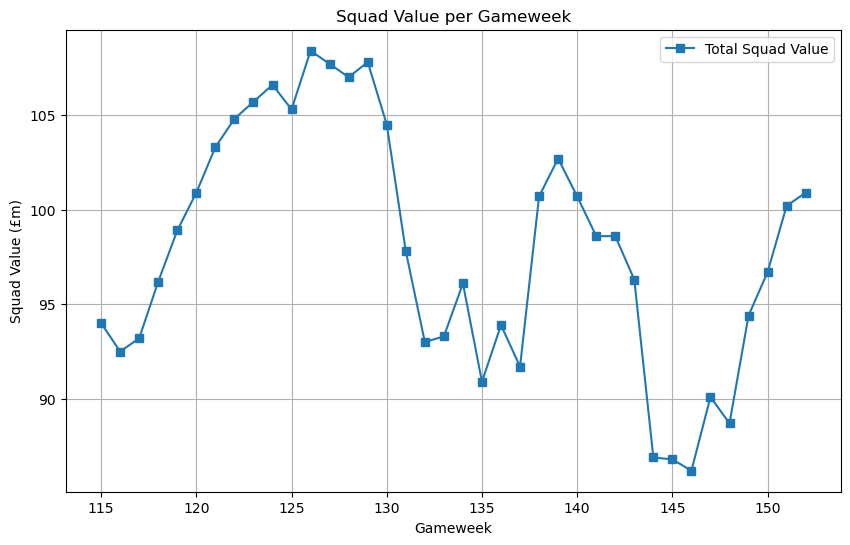

In [346]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to apply captain and chip logic
def apply_captain_points(gw_data, captain, triple_captain_gw, gw, predicted=True):
    if predicted:
        captain_points = gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]
    else:
        captain_points = gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]
    
    # Double captain points for regular GWs
    if gw == triple_captain_gw:
        return 2 * captain_points  # Triple Captain (already counted once, so we add double the captain's points)
    else:
        return captain_points  # Add captain points once (doubling already done when adding first time)


def simulate_full_season_with_chips(data, initial_starting_11, initial_bench, free_transfers=1, max_transfers=1, transfer_cost=4, formation=None, lookahead_gws=5):
    total_predicted_points = 0
    total_actual_points = 0
    gw_predictions = []
    gw_actuals = []
    gw_values = []
    chip_usage = []  # To track chip usage per GW
    
    current_starting_11 = initial_starting_11.copy()
    current_bench = initial_bench.copy()
    transfer_bank = free_transfers

    # Find best weeks for using chips
    wildcard_gw = 132  # Wildcard fixed for GW 132
    free_hit_gw = 141  # Free Hit fixed for GW 115
    triple_captain_gw = 123  # Example of Triple Captain GW (you can determine dynamically if needed)
    bench_boost_gw = 151  # Example of Bench Boost GW (you can determine dynamically if needed)

    for gw in range(115, 153):
        print(f"\nProcessing Gameweek {gw}")
        
        # Update player IDs for the current gameweek
        current_starting_11, current_bench = update_player_ids(current_starting_11, current_bench, gw)
        
        gw_data = data[data['GW'] == gw]
        gw_data = remove_duplicate_players(gw_data)

        # Create position mapping
        position_mapping = dict(zip(gw_data['unique_player_id'], gw_data['position']))

        # Apply chips
        if gw == wildcard_gw:
            print(f"Using Wildcard in GW {gw}")
            current_starting_11, current_bench = manually_input_team(gw)
            chip_usage.append("Wildcard")
        elif gw == free_hit_gw:
            print(f"Using Free Hit in GW {gw}")
            current_starting_11, current_bench = manually_input_team(gw)
            chip_usage.append("Free Hit")
        else:
            chip_usage.append("")  # No chip used this week
            
            # Handle transfers
            if transfer_bank > 0:
                for _ in range(min(transfer_bank, max_transfers)):
                    current_starting_11, current_bench, made_transfer = fpl_optimizer_one_transfer_multi_gw(
                        gw_data, current_starting_11, current_bench, data, gw, lookahead_gws=lookahead_gws, formation=formation)
                    if made_transfer:
                        transfer_bank -= 1
                    else:
                        break
            
            # Perform bench substitutions
            current_starting_11, current_bench = fpl_optimizer_with_bench_sub(gw_data, current_starting_11, current_bench, formation)

        # Adjust formation if necessary
        current_starting_11, current_bench = adjust_formation(current_starting_11, current_bench, position_mapping)

        # Assign captain and vice-captain
        captain, vice_captain = assign_captain_and_vice_captain(current_starting_11, gw_data)

        # Calculate points for the gameweek
        starting_11_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['Predicted_Points'].sum()
        bench_points = gw_data[gw_data['unique_player_id'].isin(current_bench)]['Predicted_Points'].sum()

        # Handle Triple Captain and Captain Points
        if gw == triple_captain_gw and captain:
            print(f"Using Triple Captain on {captain} in GW {gw}")
            captain_points = gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]
            starting_11_points += 2 * captain_points  # Triple Captain (adding two times the captain points)
            chip_usage[-1] = "Triple Captain"
        elif captain:
            captain_points = gw_data[gw_data['unique_player_id'] == captain]['Predicted_Points'].values[0]
            starting_11_points += captain_points  # Double Captain

        # Bench Boost points
        if gw == bench_boost_gw:
            print(f"Using Bench Boost in GW {gw}")
            current_predicted_points = starting_11_points + bench_points
            chip_usage[-1] = "Bench Boost"
        else:
            current_predicted_points = starting_11_points

        # Calculate actual points
        current_actual_points = gw_data[gw_data['unique_player_id'].isin(current_starting_11)]['next_GW_total_points'].sum()
        if gw == triple_captain_gw and captain:
            captain_actual_points = gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]
            current_actual_points += 2 * captain_actual_points  # Triple Captain
        elif captain:
            captain_actual_points = gw_data[gw_data['unique_player_id'] == captain]['next_GW_total_points'].values[0]
            current_actual_points += captain_actual_points  # Double Captain

        # Squad value
        total_squad_value = gw_data[gw_data['unique_player_id'].isin(current_starting_11 + current_bench)]['value'].sum()

        # Print gameweek information
        print(f"\nGameweek {gw} - Starting 11:")
        print(gw_data[gw_data['unique_player_id'].isin(current_starting_11)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])
        print(f"Bench for GW {gw}:")
        print(gw_data[gw_data['unique_player_id'].isin(current_bench)][['name', 'team', 'position', 'Predicted_Points', 'next_GW_total_points', 'value']])

        # Update total points and store gameweek data
        total_predicted_points += current_predicted_points
        total_actual_points += current_actual_points
        gw_predictions.append(current_predicted_points)
        gw_actuals.append(current_actual_points)
        gw_values.append(total_squad_value)

        # Reset transfer bank and add free transfer for next gameweek
        transfer_bank = min(transfer_bank + free_transfers, 2)

        print(f"Predicted Points for GW {gw}: {current_predicted_points}")
        print(f"Actual Points for GW {gw}: {current_actual_points}")
        print(f"Total Squad Value: {total_squad_value}")

    return total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage

# Plotting results with chip usage
def plot_results(gw_predictions, gw_actuals, gw_values, chip_usage):
    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_predictions, label='Predicted Points', marker='o')
    plt.plot(range(115, 153), gw_actuals, label='Actual Points', marker='x')

    # Highlight chip usage
    for idx, chip in enumerate(chip_usage):
        if chip:
            plt.text(115 + idx, max(gw_predictions[idx], gw_actuals[idx]) + 5, chip, color='red', fontsize=8)

    plt.xlabel('Gameweek')
    plt.ylabel('Points')
    plt.title('Predicted vs Actual Points per Gameweek (with chip optimization)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(115, 153), gw_values, label='Total Squad Value', marker='s')
    plt.xlabel('Gameweek')
    plt.ylabel('Squad Value (£m)')
    plt.title('Squad Value per Gameweek')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
total_predicted_points, total_actual_points, gw_predictions, gw_actuals, gw_values, chip_usage = simulate_full_season_with_chips(
    data, initial_starting_11, initial_bench, lookahead_gws=5)

print(f"\nTotal Predicted Points for the full season: {total_predicted_points}")
print(f"Total Actual Points for the full season: {total_actual_points}")

# Plot the results
plot_results(gw_predictions, gw_actuals, gw_values, chip_usage)
